<a href="https://colab.research.google.com/github/perch97/dl_hse/blob/main/shw_03_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [7]:
import torch

import numpy as np
import dataset
from dataset import TextDataset



In [8]:
train_set = dataset.TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = dataset.TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [9]:
train_set.ids2text([1000])


'ребен'

In [ ]:
train_set.ids2text([100])


'ча'

In [10]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759
for i in range(10):
    for i in range(9):
        for i in range(5):
            for dataset in (train_set, valid_set):
                indices, length = dataset[np.random.randint(len(dataset))]

                assert indices.shape == (dataset.max_length, )
                assert indices[0].item() == dataset.bos_id
                assert (indices == dataset.eos_id).sum().item() == 1

                eos_pos = indices.tolist().index(dataset.eos_id)
                assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
                #print('Indices: ',indices)
                #print('dataset.pad_id: ',dataset.pad_id)
                print(i)
                print('length: ',length)
                print((indices != dataset.pad_id).sum())

                assert (indices != dataset.pad_id).sum() == length

0
length:  48
tensor(48)
0
length:  44
tensor(44)
1
length:  35
tensor(35)
1
length:  50
tensor(50)
2
length:  31
tensor(31)
2
length:  30
tensor(30)
3
length:  41
tensor(41)
3
length:  41
tensor(41)
4
length:  26
tensor(26)
4
length:  20
tensor(20)
0
length:  41
tensor(41)
0
length:  24
tensor(24)
1
length:  38
tensor(38)
1
length:  31
tensor(31)
2
length:  17
tensor(17)
2
length:  14
tensor(14)
3
length:  82
tensor(82)
3
length:  30
tensor(30)
4
length:  69
tensor(69)
4
length:  32
tensor(32)
0
length:  23
tensor(23)
0
length:  25
tensor(25)
1
length:  47
tensor(47)
1
length:  31
tensor(31)
2
length:  14
tensor(14)
2
length:  27
tensor(27)
3
length:  36
tensor(36)
3
length:  28
tensor(28)
4
length:  42
tensor(42)
4
length:  20
tensor(20)
0
length:  31
tensor(31)
0
length:  48
tensor(48)
1
length:  71
tensor(71)
1
length:  29
tensor(29)
2
length:  43
tensor(43)
2
length:  44
tensor(44)
3
length:  33
tensor(33)
3
length:  57
tensor(57)
4
length:  25
tensor(25)
4
length:  31
tensor(31)


## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [14]:
from model import LanguageModel

In [15]:
model = LanguageModel(train_set)

In [16]:
model = LanguageModel(train_set)
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    print(logits.shape == (bs, lengths.max(), train_set.vocab_size))
    print(logits.shape)
    print((bs, lengths.max(), train_set.vocab_size))
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)
    print(generated)

True
torch.Size([1, 6, 2000])
(1, tensor(6), 2000)
True
torch.Size([4, 108, 2000])
(4, tensor(108), 2000)
True
torch.Size([16, 113, 2000])
(16, tensor(113), 2000)
True
torch.Size([64, 125, 2000])
(64, tensor(125), 2000)
True
torch.Size([256, 128, 2000])
(256, tensor(128), 2000)
кла домойторщееценвод быстро програм россия мед сна про двоесяветсли ново соз разве никтоонщи наконец неде всяпро язоваться пи нарко паренькра начинанюльное руитадалрю никто жа люблю пожалуйста какой бросколько попро лучшетрарю кита женщина мальчикзя люди мужчинтреобра тя ничегоченвер ан - пар этотницечнойщее интересно россияшком оши выпи вашикус назынахчтонный недо мерступ женщи знажилну без мужикиятсяйтистоя сускую смотрит трамытивняянали бабушка те нихольного дня пьяный уда восстьингстоботанымсла мимо путиступправ телевизодели выход зи тем цен какое
купил мужик шляпу,кур хренстоввер опыщисе уме поховши мать ог слушай или про четы девочка дулось гувая моро опера кварона заколог доро ночью руки хоте тобой 5сти 

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [17]:
import torch
from torch.utils.data import DataLoader
from model import LanguageModel
from dataset import TextDataset  # Import your dataset classfrom train import train
from torch.utils.data import DataLoader
from train import train, plot_losses

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
#val_loader = DataLoader(valid_set, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False)
scheduler = None

model = LanguageModel(train_set)
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 10
#model.cuda()


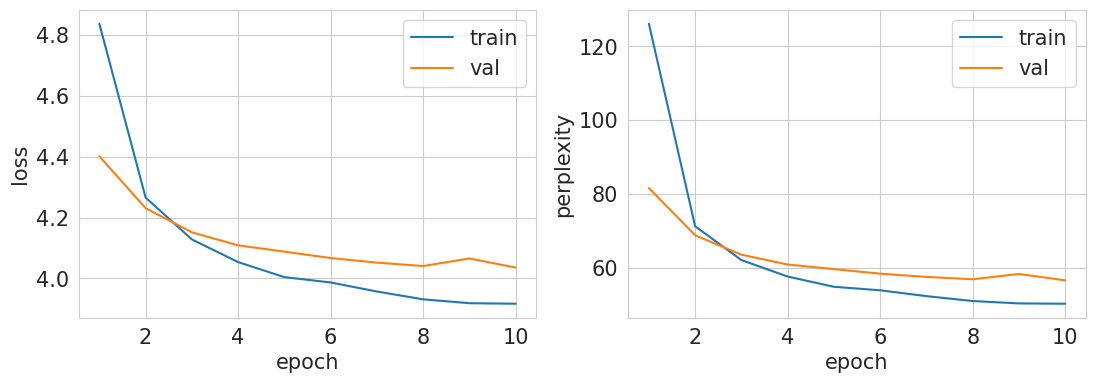

Generation examples:
чтобы когда люди в интическом здании с дневной- меня вчера кровь нужен интернет, тяжелый год.
в камасут лопаса, но так по ограть, стула крета.- меня вчера у тебя теперь вашу огурда, не боковое, когда они хотят?
мужик заботятся по отделению сидения в интернете- я йогурт отсутствующей среда...
мало после него старой сдохли! откажут никто и операция кастрюлькинка и бреет погуляю...
заходит в диете до сих пор обратился и родила на российских гаральной машины конкурсает за знаменитикты.


In [18]:
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


In [ ]:
torch.save(model, 'LSTM.pt')


## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [19]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM)
optimizer = torch.optim.Adam(model.parameters())

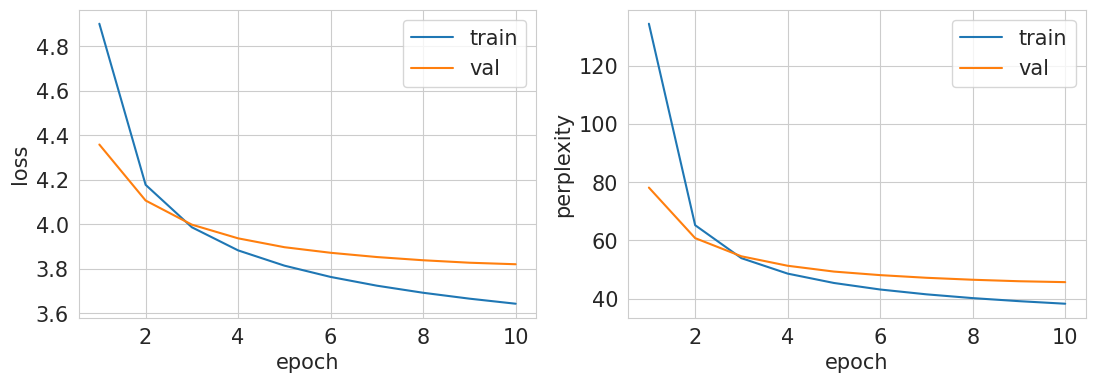

Generation examples:
уххот озабоченко и у него теща окончилась. малоправил кошкой, блин и говорит мужу- не хватает мне плохого мужчины - эксперты.- он подсказала, что ему понятно!
- ты в первый раз в жизни она удал целый! наверное, все познакомились?- да.- аж ты мне налоги кормят?
муж посмотрел на аптеток- мама, а у ваши шарина, живешь бесподь?президент разве- глядя на меня очень и теперь у меня есть пиво - мыши!
состояние модерзей настолько, что они могут сравниться с вами, а теперь вынес произносить столько новых казни.
женщинам очень быстро послал окна, всегда очень плохо, когда учиться надо нормально, некрасивая, начиненные раси бстгает на него, получили против, дышать в старых, убомывают ошибки сидоров все доступные женщины, бросают на миллион долларов.


In [20]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [25]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
for temp in np.arange(0.1, 1, 0.1):
    print(temp)
    for prefix in ['', 'вовочка', 'петька и василий иваныч', 'пришел мужик к брежневу и сказал']:
        print(model.inference(prefix, temp))
        print()

0.1
- а вы знаете, что у вас в школе?- я не знаю, что я не могу понять, что я не могу понять, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю

вовочкаснимает с собой- а ты что, не помню, как ты думаешь, что ты не знаешь, что я не могу?- я не знаю, что я не знаю, что я не знаю, что я знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что ты не знаешь, что ты не будешь.

петька и василий иваныч, а у меня в постели.

пришел мужик к брежневу и сказал- а я вчера нашел на работу, а потом я вышла замуж за тебя.- а ты что, не выбрал?- да, я иду в магазин, а я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, чт

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [30]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
train_set = TextDataset(data_file='jokes.txt',vocab_size=4000, train=True, sp_model_prefix='bpe_4000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000,train=False, sp_model_prefix='bpe_4000')


train_loader = DataLoader(train_set, batch_size=64)
val_loader = DataLoader(valid_set, batch_size=64)

In [31]:
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM)
optimizer = torch.optim.Adam(model.parameters())



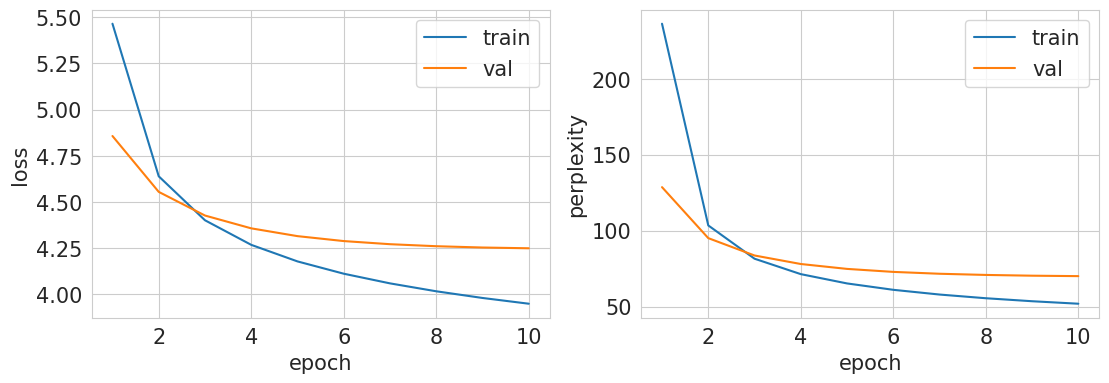

Generation examples:
- папа, а у него всегда любишь?- чтоб здоровье все, что совсем плохо.
позелит скатерть монтял по одной петербурской носка.
встречаются два крокопатых мужика и загадки и пожилые кушаются.- дорогая, белая- понимаете, мне так понравилось, что ты любишь рыба, к ней дело давно даже не поздно!- опять еще оставались в отличие от запонки и хочу какая-то.- но потом их с полкают.- что, она ему гад кофе достала футболисты?- а это - минуту перепутал там эстонская форму кашельда и срыве на задницу.
- ты слышал?- это вчера в большом пальтовом состоянии пришли с мешкомку сперманами...- мама?- да, не психа птице.- да она вы меня.
- как вы понимаете про блондинок, пожалуйста или в розетки?- это хорошо.- не могу. ходите в телефоны давай выйду из под руки.


In [32]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [33]:
torch.save(model, 'LSTM_BPE_4000.pt')


In [35]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
train_set = TextDataset(data_file='jokes.txt', model_type='word', train=True, sp_model_prefix='unigram')
valid_set = TextDataset(data_file='jokes.txt', model_type='word', train=False, sp_model_prefix='unigram')

train_loader = DataLoader(train_set, batch_size=64)
val_loader = DataLoader(valid_set, batch_size=64)

In [36]:
model_4 = LanguageModel(train_set, rnn_type=torch.nn.LSTM)
optimizer = torch.optim.Adam(model.parameters())



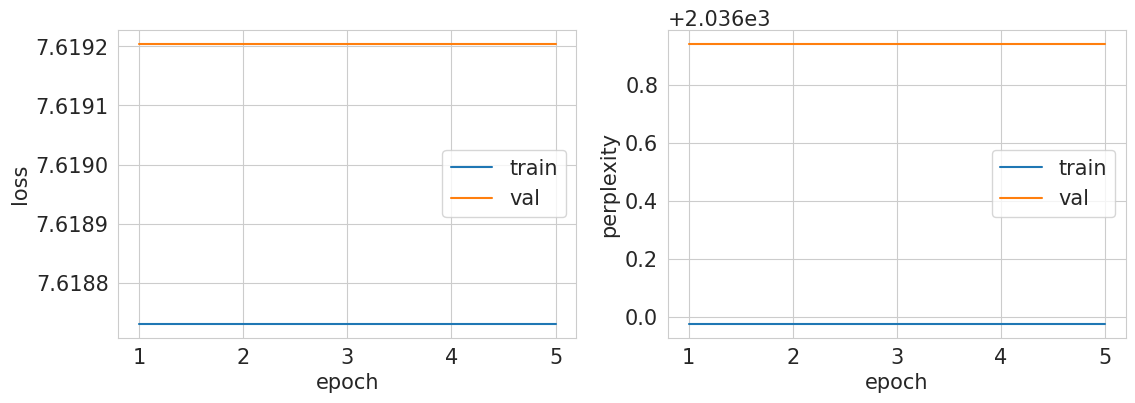

Generation examples:
вышел считает, мужика дела?- понимаю в чувство, мир понял, истории два вокруг словами самые правду мороз парень, яйца кровати менее выходные спасибо года красивые русский дороги неужели дорогая, меньше принять затем немного мужу купи семья мозг любил штаны кем судя поставил чем помню, абрам, мой кем возможно, результате полиция программист зовут я видите 20 нравится, обещал убить давать все-таки руку лесу видите бывают 10 далеко мужчине российских вся ними а, понять люблю слово зачем дед странно, грамм собака чувствую мысль раз, пять специально другой сможет ли, говорил, нет прошел немного российский останавливает об увидел пришлось нами снимает человека, тебя, из-под книгу мужик всякий попал уши давайте пить, штирлица лето которого люди, твоих пойти сидеть каждую ой, ушел понимаете, судя скажет главное, вопрос меня могу, тянет самого чиновников скажи,
тетя кто-нибудь вам, хлеб москвы чувство, ждет поле ли, говорит скажите, поле новости лучшее сидит отпуск понятно,

In [38]:
train(
    model=model_4,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5
)

In [39]:
torch.save(model_4, 'LSTM_UNI.pt')


## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [42]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm.auto import tqdm


def LSA(model_path, data_file, vocab_size, sp_model_prefix):
    model = torch.load(model_path)

    X_val = TextDataset(data_file=data_file, vocab_size=vocab_size, train=False, sp_model_prefix=sp_model_prefix)

    X_val_real = X_val.ids2text(X_val.indices)
    X_val_generated = [model.inference() for i in tqdm(range(len(X_val)))]


    X_val_full = X_val_real + X_val_generated


    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(X_val_full)

    svd = TruncatedSVD(n_components=50, random_state=42)
    X_svd = svd.fit_transform(X)

    split = len(X_val_real)

    real_vecs = X_svd[:split, :]
    generated_vecs = X_svd[split:, :]

    cosine = cosine_similarity(generated_vecs, real_vecs).max(axis=1).mean()
    return cosine, real_vecs, generated_vecs

In [43]:
models = [ 'LSTM_BPE_4000.pt', 'LSTM_UNI.pt',]
prefixes = [ 'bpe_4000', 'unigram']
real_vecs = []
generated_vecs = []
for model_name, prefix in zip(models, prefixes):
    score, real, generated = LSA(
        model_path='' + model_name,
        data_file='jokes.txt',
        vocab_size=10,
        sp_model_prefix=prefix
    )
    real_vecs.append(real)
    generated_vecs.append(generated)

    print(model_name, score)

  0%|          | 0/6037 [00:00<?, ?it/s]

LSTM_BPE_4000.pt 0.8140490002676974


  0%|          | 0/6037 [00:00<?, ?it/s]

LSTM_UNI.pt 0.7609953779041239


## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [44]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

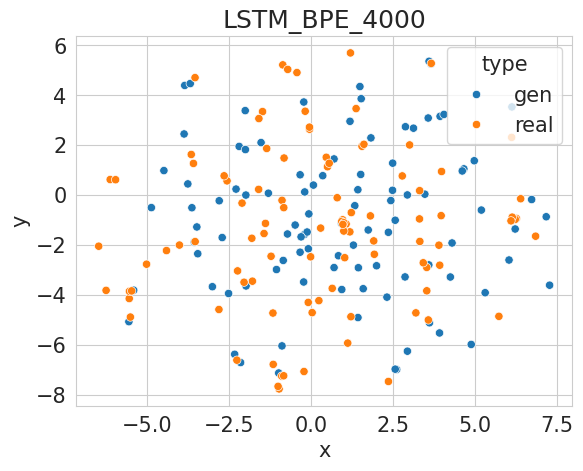

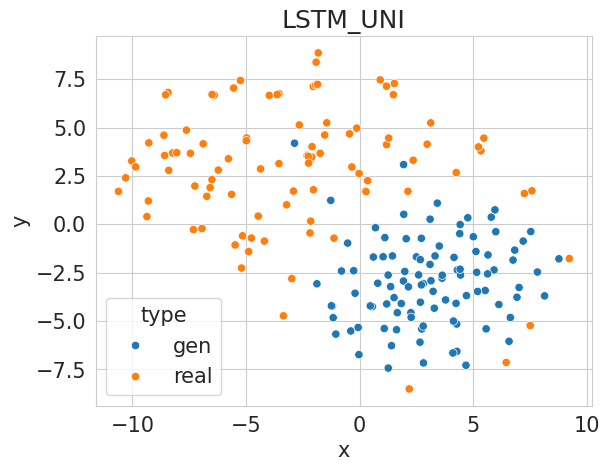

In [45]:
models = ['LSTM_BPE_4000.pt', 'LSTM_UNI.pt']


for i, name in enumerate(models):

    real = real_vecs[i]
    gen = generated_vecs[i]

    idx1 = np.random.randint(gen.shape[0], size=100)
    idx2 = np.random.randint(real.shape[0], size=100)

    data = np.concatenate((gen[idx1, :], real[idx2, :]), axis=0)
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')

    data_embedded = tsne.fit_transform(data)

    df = pd.DataFrame({
        'x': data_embedded[:, 0],
        'y': data_embedded[:, 1],
        'type': ['gen'] * 100 + ['real'] * 100
    })

    ax = sns.scatterplot(data=df, x="x", y="y", hue="type")
    ax.set_title(name.replace('.pt', ''))
    plt.show()


## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [46]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from transformers import AutoTokenizer, AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
def gpt_perplexity(encodings):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)
    sample_size=1000

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    ppl = torch.exp(torch.stack(nlls).mean())

    return ppl.item()

In [49]:
models = [ 'LSTM_BPE_4000.pt', 'LSTM_UNI.pt']
for i in tqdm(models):
    language_model = torch.load(''+i)

    generated = [language_model.inference() for i in range(1000)]
    encodings = tokenizer("\n\n".join(generated), return_tensors="pt")

    ppl = gpt_perplexity(encodings)
    print(i.replace('.pt', ''), ppl)

  0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (30008 > 2048). Running this sequence through the model will result in indexing errors


LSTM_BPE_4000 470.1574401855469
LSTM_UNI 2024.7452392578125


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.